In [19]:
import pandas as pd
import numpy as np
import missingno as msn
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [20]:
df = pd.read_csv('train1.csv')
val = pd.read_csv('val.csv')
#X_train, X_val, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#.describe()

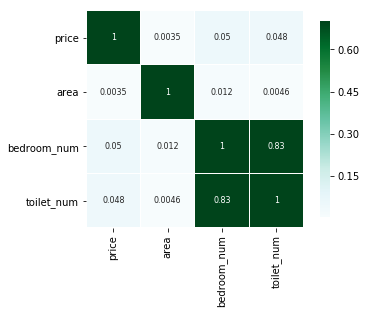

In [21]:
sns.heatmap(df.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},cbar_kws={"shrink": .9});

count    9.173000e+03
mean     4.176533e+09
std      3.684227e+09
min      5.000000e+08
25%      1.350000e+09
50%      3.200000e+09
75%      5.700000e+09
max      2.000000e+10
Name: price, dtype: float64


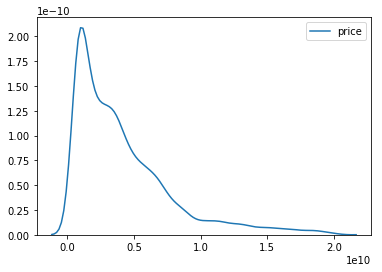

In [22]:
#Từ đây ta lọc giá thuộc 500 triệu đến 20 tỷ, rồi vẽ
df = df[df.price>=5e8] 
df = df[df.price<=2e10]
print(df['price'].describe())
sns.kdeplot(df.price)

count    8932.000000
mean       72.184729
std        45.028824
min         1.000000
25%        42.000000
50%        60.000000
75%        87.000000
max       256.000000
Name: area, dtype: float64

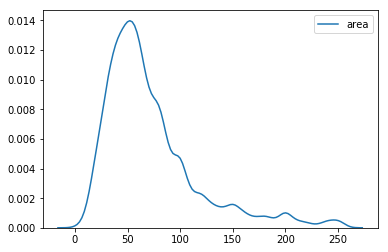

In [23]:
#sns.scatterplot(x = train.area, y= train.price)
#su phân bố diện tích
df = df[df['area']<260]
sns.kdeplot(df.area)
df.area.describe()

In [24]:
df['area'] = df['area'].apply(lambda x: x if x < 260  else -1) #diện tích lớn hơn 260 cho vô 1 bin


(số phòng ngủ, số lượng)
(1, 833)
(2, 3196)
(3, 1825)
(4, 1938)
(5, 546)
(6, 242)
(7, 55)
(8, 70)
(9, 21)
(10, 75)
(11, 122)


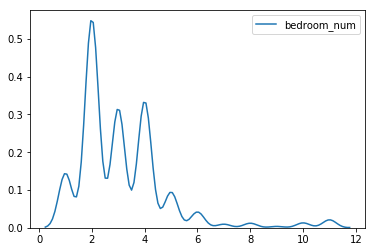

In [25]:
print("(số phòng ngủ, số lượng)")
for i in range(1,12):
    are1 = df[df['bedroom_num']< i]
    are2 = df[df['bedroom_num']< i+1]
    print((i,  are2.bedroom_num.count() - are1.bedroom_num.count()))
    
sns.kdeplot(df.bedroom_num)

In [26]:
df['bedroom_num'] = df['bedroom_num'].apply(lambda x: x if x < 7  else -1) # lớn hơn 7 phòng ngủ cho vô 1 bin

(số phòng vệ sinh, số lượng)
(1, 1250)
(2, 2593)
(3, 1532)
(4, 886)
(5, 571)
(6, 162)
(7, 247)


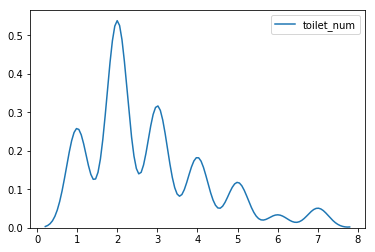

In [27]:
print("(số phòng vệ sinh, số lượng)")
for i in range(1,8):
    are1 = df[df['toilet_num']< i]
    are2 = df[df['toilet_num']< i+1]
    print((i,  are2.toilet_num.count() - are1.toilet_num.count()))

sns.kdeplot(df.toilet_num)

In [28]:
df['toilet_num'] = df['toilet_num'].apply(lambda x: x if x < 6  else -1) # lớn hơn 6 phòng ngủ cho vô 1 bin

In [193]:
class CatePriceDrop(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
#         train = X_df
#         train = train[train.price>=1e8] 
#         train = train[train.price<=2e10]
        
#         self_25 = train
        
        details = train.price.describe()
        
        self._25 = details['25%']
        self._50 = details['50%']
        self._75 = details['75%']
        return self
    
    def to_cate(self, x):
        if x < self._25:
            return 1
        if x < self._50:
            return 2
        if x < self._75:
            return 3
        return 4
    
#     def transform(self, X_df, y=None):
#         res_df = X_df.copy()
#         res_df['label'] = res_df['price'].apply(lambda x: self.to_cate(x))
#         res_df['type'] = res_df['type'].apply(lambda x: x if x == 'Môi giới' else 'Khác')
#         res_df.drop(columns=['price','time','link','address',
#                              'title','city','description',
#                              'block_name','total_floor','direction'], inplace=True)
    def transform(self, X_df, y=None):
        res_df = X_df.copy()
        res_df['label'] = res_df['price'].apply(lambda x: self.to_cate(x))
        res_df['type'] = res_df['type'].apply(lambda x: x if x == 'Môi giới' else 'Khác')
        res_df.drop(columns=['price','time','link','address',
                             'title','city','description','block_name', 'direction', 'total_floor'
                             ], inplace=True)
        return res_df

In [194]:
cate = CatePriceDrop()
train_transform = cate.fit_transform(df)
val = cate.transform(val)
train_transform.sample(1)

,type,area,bedroom_num,house_type,toilet_num,legcal_doc,housing_feature,district,ward,street,label
8978,Khác,33.0,2.0,Nhà,1.0,Đã có sổ đỏ/sổ hồng,Hẻm xe hơi,Quận 12,Phường Hiệp Thành,Đường Hiệp Thành 13,2


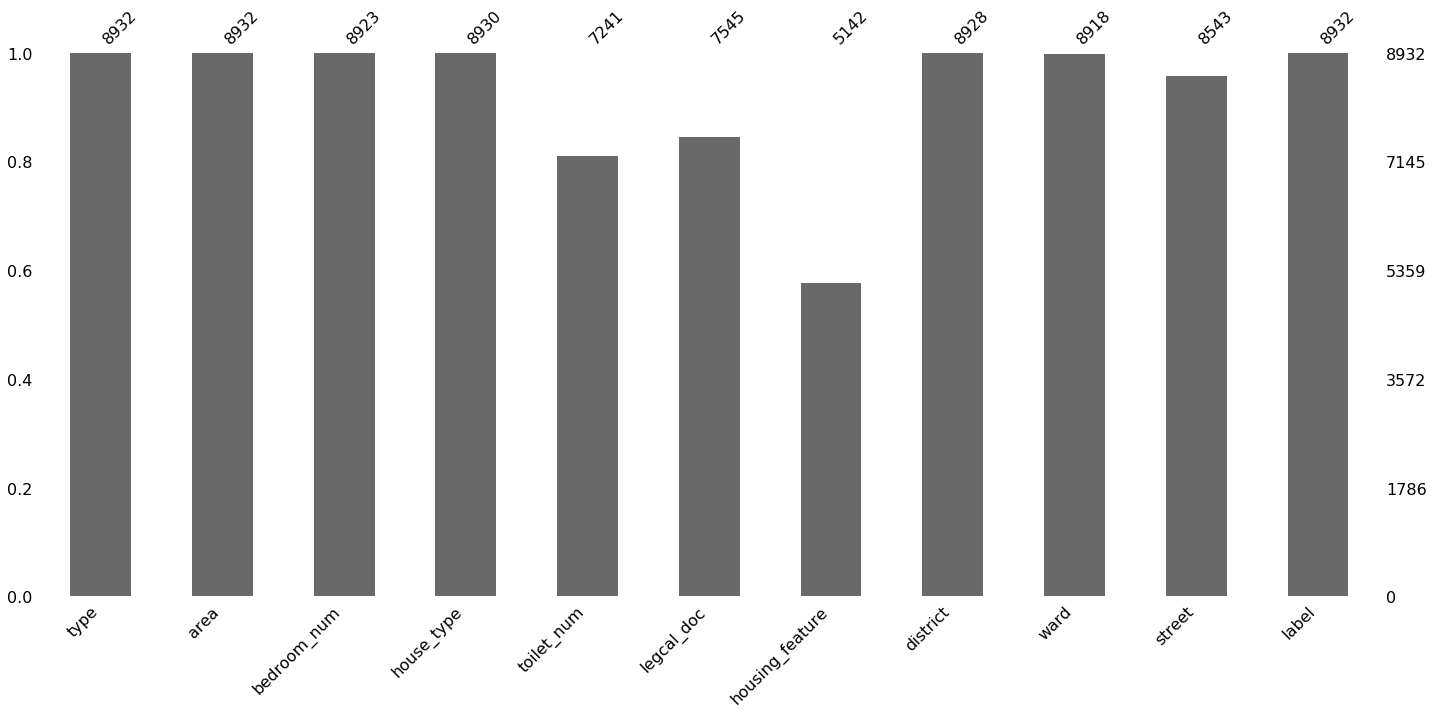

In [195]:
msn.bar(train_transform)

In [196]:
#train_transform.total_floor.describe()

In [197]:
train_transform.legcal_doc.describe()

count                    7545
unique                      3
top       Đã có sổ đỏ/sổ hồng
freq                     7200
Name: legcal_doc, dtype: object

In [198]:
train_transform.legcal_doc.unique()

array(['Đã có sổ đỏ/sổ hồng', nan, 'Giấy tay', 'Đang chờ bàn giao sổ'],
      dtype=object)

In [199]:
train_transform.housing_feature.describe()

count           5142
unique             3
top       Hẻm xe hơi
freq            2261
Name: housing_feature, dtype: object

In [200]:
train_transform.housing_feature.unique()

array(['Mặt tiền', 'Hẻm xe hơi', nan, 'Nở hậu'], dtype=object)

- Fill `toilet_num` nan with `0.0`
- Fill `legcal_doc` nan with `Không có`
- Fill `housing_feature` nan with `Khác`
- Fill `bedroom_num` nan with `0.0`
- Fill `house_type` nan with `Khác`
- Fill `district`, `ward` and `street` nan with most_frequence

In [201]:
class FillNA(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        mode_street = X_df.street.describe()['top']
        mode_district = X_df.district.describe()['top']
        mode_ward = X_df.ward.describe()['top']
        #mode_total_floor= X_df.total_floor.describe()['top']
        self.mode_cols = {'street': mode_street, 
                          'district': mode_district, 
                          'ward': mode_ward}
        return self
    
    def transform(self, X_df, y=None):
        res_df = X_df.copy()
        other_cols = ['housing_feature', 'house_type']
        _0_cols = ['bedroom_num', 'toilet_num']
        for i in self.mode_cols:
            j = self.mode_cols[i]
            res_df[i].fillna(j, inplace=True)
        for i in other_cols:
            res_df[i].fillna('Khác',inplace=True)
        for i in _0_cols:
            res_df[i].fillna(0.0,inplace=True)
        res_df['legcal_doc'].fillna('Không có', inplace=True)
        return res_df

In [202]:
fillna = FillNA()
train_pre = fillna.fit_transform(train_transform)

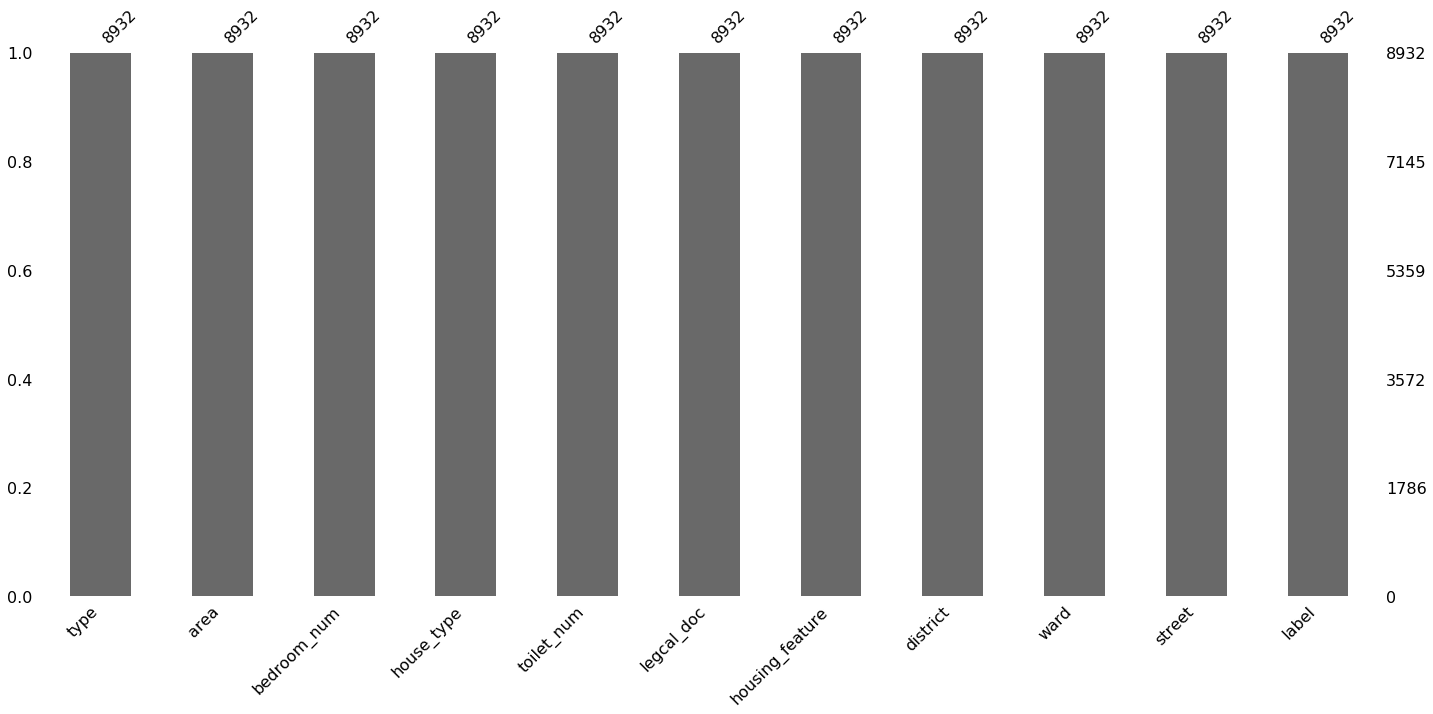

In [203]:
msn.bar(train_pre)

In [204]:
cate_cols = ['type', 'house_type', 'legcal_doc', 'housing_feature', 'district', 'ward', 'street']

scaler = StandardScaler()

pp = Pipeline(steps=[('to_cate', CatePriceDrop()), ('FillNA', FillNA())])
train_preprocess = pp.fit_transform(df)
trainY = train_preprocess['label'].values
trainX = train_preprocess.drop(columns=['label'])
onehot = OneHotEncoder(handle_unknown='ignore')
trainX = onehot.fit_transform(trainX).toarray()
trainX_Scale = scaler.fit_transform(trainX)

In [205]:
test = pd.read_csv('val.csv')
test_preprocess = pp.transform(test)
testY = test_preprocess['label'].values
testX = test_preprocess.drop(columns=['label'])
testX = onehot.transform(testX).toarray()
testX_Scale = scaler.transform(testX)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# clfs = [MLPClassifier(hidden_layer_sizes=5,tol=1e-3), RandomForestClassifier(n_jobs=4),
#         LogisticRegression()]
#clfs = [RandomForestClassifier()]
clfs = [svm.SVC(kernel='rbf')]
for clf in clfs:
    print(clf)
    clf.fit(trainX_Scale, trainY)
    %time
    print('Train score:', clf.score(trainX_Scale, trainY))
    print('Test score:', clf.score(testX_Scale, testY))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Wall time: 0 ns
Train score: 0.7183161665920287


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

clfs = [MLPClassifier(hidden_layer_sizes=5,tol=1e-3), RandomForestClassifier(n_jobs=4),
        LogisticRegression()]

for clf in clfs:
    print(clf)
    clf.fit(trainX_Scale, trainY)
    %time
    print('Train score:', clf.score(trainX_Scale, trainY))
    print('Test score:', clf.score(testX_Scale, testY))

(14193,)